# 🤖 Eksperimen 3: Hybrid ASR + Local LLM (Ollama)
**Researcher:** Muhammad Hendika Putra  
**Method:** Pipeline ASR (Whisper) -> Text Correction (Ollama)  
**Dataset:** Google FLEURS (Indonesia)

---
### 💡 Hipotesis
Model ASR sering menghasilkan teks "mentah" (tanpa tanda baca/kapitalisasi) atau salah eja pada nama entitas. LLM dapat bertindak sebagai *Post-Processor* untuk memperbaiki struktur kalimat tanpa mengubah makna, sehingga menurunkan **WER (Word Error Rate)** dan meningkatkan keterbacaan.

### Perbedaan Utama dengan Eksperimen 2:
1.  **LLM Backend:** Mengganti Google Gemini (Cloud) dengan Ollama (Local).
2.  **Kecepatan:** Menghapus time.sleep() karena model lokal tidak memiliki batas Rate Limit.
3.  **Model:** Menggunakan Qwen 2.5 (1.5B) yang ringan dan cepat

### ⚙️ Alur Kerja (Pipeline)
1.  **Input Audio:** Suara manusia (Dataset FLEURS).
2.  **ASR Engine:** Mengubah suara menjadi Teks Mentah (*Raw Transcript*).
3.  **LLM Corrector:** Mengirim Teks Mentah ke Gemini dengan prompt khusus untuk perbaikan tata bahasa.
4.  **Evaluasi:** Membandingkan WER antara (Raw vs Ground Truth) dan (LLM vs Ground Truth).

In [1]:
# @title 1. Instalasi Library
%pip install ollama datasets jiwer soundfile librosa torch transformers pandas matplotlib seaborn tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\muham\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📡 Connect to Google FLEURS...
👂 Loading ASR Model: openai/whisper-tiny di cuda:0...


Device set to use cuda:0
Using `chunk_length_s` is very experimental with seq2seq models. The results will not necessarily be entirely accurate and will have caveats. More information: https://github.com/huggingface/transformers/pull/20104. Ignore this warning with pipeline(..., ignore_warning=True). To use Whisper for long-form transcription, use rather the model's `generate` method directly as the model relies on it's own chunking mechanism (cf. Whisper original paper, section 3.8. Long-form Transcription).


🧠 Loading Local LLM: qwen2.5:1.5b via Ollama...

🚀 Memulai Eksperimen 3 pada 15 data...


100%|██████████| 15/15 [00:49<00:00,  3.33s/it]


🔍 CONTOH HASIL (8 Angka Belakang Koma):


,WER_Raw,WER_LLM,Time_ASR,Time_LLM
0,0.28571429,0.14285714,2.50892806,13.67448711
1,0.66666667,0.55555556,0.54903650,0.74056602
2,0.47058824,0.47058824,0.44288087,0.90598536
3,0.33333333,0.50000000,0.29582167,0.64252114
4,0.50000000,0.22727273,1.10064554,1.10952330


C:\Users\muham\AppData\Local\Temp\ipykernel_5032\1419859389.py:202: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Metode', y='WER Score', data=data_plot, palette=['gray', 'blue'])



📊 STATISTIK AKHIR (Presisi Tinggi)
Rata-rata WER ASR Murni : 0.47771087
Rata-rata WER + Qwen    : 0.48514588
Peningkatan Kinerja     : -1.55638224%
Rata-rata Waktu Total   : 2.80055672 detik
✅ Hasil disimpan ke: exp3_local_hybrid_results5.csv


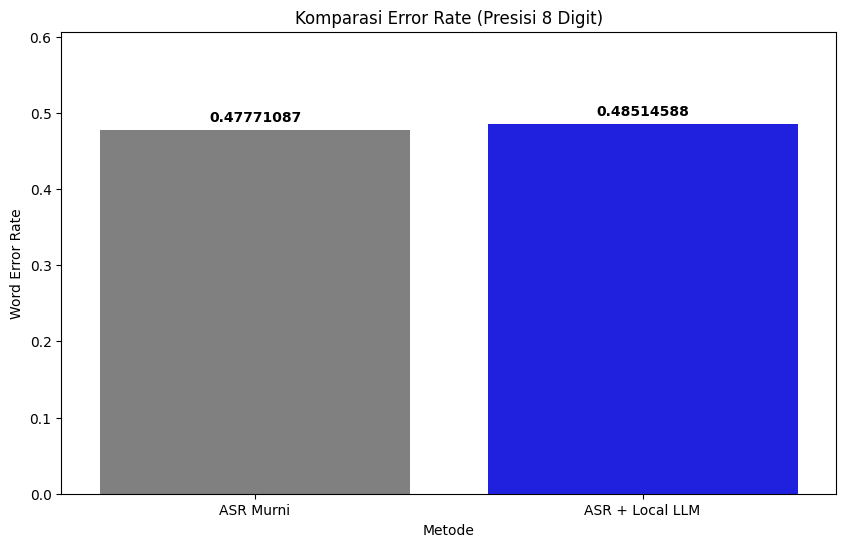

In [ ]:
import torch
from transformers import pipeline
from jiwer import wer
import pandas as pd
from tqdm import tqdm
import soundfile as sf
import os
import time
import ollama
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

# ---------------------------------------------------------
# 1. KONFIGURASI & SETUP
# ---------------------------------------------------------
MODEL_ASR_ID = "openai/whisper-tiny"
MODEL_LLM_LOCAL = "qwen2.5:1.5b"  # Pastikan sudah 'ollama pull qwen2.5:1.5b'
NUM_SAMPLES = 15
OUTPUT_FOLDER = "exp3_local_results5_audio"

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# 🔥 SETTING PRESISI 8 ANGKA DI BELAKANG KOMA UNTUK PANDAS 🔥
pd.options.display.float_format = '{:.8f}'.format

# ---------------------------------------------------------
# 2. DEFINISI MODUL
# ---------------------------------------------------------

class ASRModule:
    def __init__(self, model_id):
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        print(f"👂 Loading ASR Model: {model_id} di {self.device}...")
        self.pipe = pipeline(
            "automatic-speech-recognition",
            model=model_id,
            chunk_length_s=30,
            device=self.device
        )

    def transcribe(self, audio_array):
        res = self.pipe(audio_array, batch_size=1, generate_kwargs={"language": "indonesian"})
        return res['text']

class LocalLLMCorrector:
    def __init__(self, model_name):
        print(f"🧠 Loading Local LLM: {model_name} via Ollama...")
        self.model_name = model_name

    def correct_text(self, raw_text):
        system_prompt = (
            "Anda adalah mesin koreksi teks ASR (Automatic Speech Recognition) untuk Bahasa Indonesia. "
            "Tugas Anda HANYA memperbaiki ejaan yang salah dan tanda baca. "
            "\n\n"
            "ATURAN MUTLAK:\n"
            "1. PERTAHANKAN JUMLAH KATA: Jangan menambah atau mengurangi kata kecuali benar-benar diperlukan.\n"
            "2. PERTAHANKAN BUNYI: Jika teks mentah terdengar seperti 'kambing', jangan ubah menjadi 'karena' walaupun konteksnya aneh.\n"
            "3. JANGAN PARAFRASE: Dilarang mengubah struktur kalimat.\n"
            "4. KAPITALISASI: Perbaiki huruf besar untuk nama diri, tempat, dan awal kalimat.\n"
            "\n\n"
            "CONTOH (Ikuti pola ini):\n"
            "Input: tim tim virtual memiliki standard keunggulan\n"
            "Output: Tim-tim virtual memiliki standar keunggulan.\n"
            "\n"
            "Input: diisisi lain kondisi yang tingin dan persaal juter kolong normal\n"
            "Output: Di sisi lain, kondisi yang dingin dan bersalju tergolong normal.\n"
            "\n"
            "Input: diaisiti lain keadaan tetap\n"
            "Output: Di sisi lain keadaan tetap.\n"
        )
        
        try:
            # options={'temperature': 0.1} sangat krusial untuk task perbaikan teks
            response = ollama.chat(
                model=self.model_name, 
                messages=[
                    {'role': 'system', 'content': system_prompt},
                    {'role': 'user', 'content': f"Input: {raw_text}\nOutput:"},
                ],
                options={'temperature': 0.1, 'top_p': 0.9} 
            )
            
            result = response['message']['content'].strip()
            
            # Post-processing ringan untuk membersihkan jika model masih chatty
            if "Output:" in result:
                result = result.split("Output:")[-1].strip()
            if result.startswith('"') and result.endswith('"'):
                result = result[1:-1]
                
            return result
        except Exception as e:
            print(f"[Ollama Error] {e}")
            return raw_text

class HybridPipelineLocal:
    def __init__(self):
        self.asr = ASRModule(MODEL_ASR_ID)
        self.llm = LocalLLMCorrector(MODEL_LLM_LOCAL)
        self.results = []

    def run(self, dataset_stream, num_samples):
        print(f"\n🚀 Memulai Eksperimen 3 pada {num_samples} data...")
        
        counter = 0
        for sample in tqdm(dataset_stream, total=num_samples):
            if counter >= num_samples: break

            # Data
            audio = sample['audio']['array']
            sr = sample['audio']['sampling_rate']
            ground_truth = sample['raw_transcription']
            
            # Save Audio
            sf.write(os.path.join(OUTPUT_FOLDER, f"sample_{counter:03d}.wav"), audio, sr)

            # ASR Process
            start_t = time.time()
            raw_text = self.asr.transcribe(audio)
            time_asr = time.time() - start_t

            # LLM Process
            start_t = time.time()
            corrected_text = self.llm.correct_text(raw_text)
            time_llm = time.time() - start_t
            
            # Evaluasi
            try:
                wer_raw = wer(ground_truth.lower(), raw_text.lower())
                wer_llm = wer(ground_truth.lower(), corrected_text.lower())
            except:
                wer_raw = 1.0; wer_llm = 1.0

            self.results.append({
                "Voice": f"sample_{counter:03d}.wav",
                "Ref": ground_truth,
                "Pred_Raw": raw_text,
                "Pred_LLM": corrected_text,
                "WER_Raw": wer_raw,
                "WER_LLM": wer_llm,
                "Time_ASR": time_asr,       # Satuan Detik
                "Time_LLM": time_llm,       # Satuan Detik
                "Time_Total": time_asr + time_llm
            })
            counter += 1
            
        return pd.DataFrame(self.results)

# ---------------------------------------------------------
# 3. EKSEKUSI
# ---------------------------------------------------------

# Load Dataset
print("📡 Connect to Google FLEURS...")
dataset_stream = load_dataset("google/fleurs", "id_id", split="test", streaming=True, trust_remote_code=True)

# Run Pipeline
pipeline = HybridPipelineLocal()
df_results = pipeline.run(dataset_stream, NUM_SAMPLES)

# Tampilkan Tabel (Format angka otomatis mengikuti setting pd.options di atas)
print("\n🔍 CONTOH HASIL (8 Angka Belakang Koma):")
pd.set_option('display.max_colwidth', None)
display(df_results[['WER_Raw', 'WER_LLM', 'Time_ASR', 'Time_LLM']].head(5))

# Statistik
avg_raw = df_results['WER_Raw'].mean()
avg_llm = df_results['WER_LLM'].mean()
avg_time_total = df_results['Time_Total'].mean()
imp = ((avg_raw - avg_llm) / avg_raw) * 100

print("\n" + "="*50)
print(f"📊 STATISTIK AKHIR (Presisi Tinggi)")
print("="*50)
print(f"Rata-rata WER ASR Murni : {avg_raw:.8f}")
print(f"Rata-rata WER + Qwen    : {avg_llm:.8f}")
print(f"Peningkatan Kinerja     : {imp:.8f}%")
print(f"Rata-rata Waktu Total   : {avg_time_total:.8f} detik")

# Simpan CSV
csv_name = "exp3_local_hybrid_results5.csv"
df_results.to_csv(
    csv_name, 
    index=False, 
    sep=';',        # Agar kolom terpisah rapi di Excel
    decimal=',',    # PENTING: Mengubah titik jadi koma agar tidak dianggap jutaan
    float_format='%.8f'
) 
print(f"✅ Hasil disimpan ke: {csv_name}")

# ---------------------------------------------------------
# 4. VISUALISASI (Update Label 8 Digit)
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
data_plot = pd.DataFrame({
    'Metode': ['ASR Murni', 'ASR + Local LLM'],
    'WER Score': [avg_raw, avg_llm]
})

ax = sns.barplot(x='Metode', y='WER Score', data=data_plot, palette=['gray', 'blue'])
plt.title(f"Komparasi Error Rate (Presisi 8 Digit)")
plt.ylabel("Word Error Rate")
plt.ylim(0, max(avg_raw, avg_llm) * 1.25)

# Menambahkan label 8 angka di atas bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.8f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontweight='bold')

plt.show()